In [1]:
!pip install --upgrade eeg-to-fmri==0.0.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Classification on EEG only datasets

In this post I will talk about the application of this package to classify EEG data. The purpose is to be able to classify an EEG alone, without an fMRI pairing, while being able to project a synthesized fMRI view.

## EEG only dataset

The dataset consists of $N$ individuals. The individuals have a set of features $X \in \mathbb{R}^{N \times C\times F\times T}$ and labels $y \in \mathbb{R}^{N \times 1}$. The notation is similar to the previous blog post, where $C$ stands for the number of channels, $F$ is the frequency resolution and $T$ is the amount of time considered of the EEG recording. An EEG instance looks like illustrated in the figure below.

<p align="center">
	<img src="http://web.ist.utl.pt/~ist180980/eeg_to_fmri/blog/figures/eeg_stft.png" width="200"/>
</p>

This image corresponds to the STFT projection of one channel. The labels are $y = \{0, 0, \dots, 1, 1\}$. Note that, we only consider binary classification problems for this setup.

## Classifying synthesized images

In this section, I will go over the methodology used to classify synthesized images (projected by sinusoids). This is the novel contribution of this [paper](https://en.wikipedia.org/wiki/HTTP_404). Let $\vec{z}_{X_i}=E(X_i; \theta_E)$ be a latent projection of the synthesizer model preceding the sinusoid projection. Since the sinusoid projection is $cos(\omega \cdot \vec{z}_{X_i} + \beta)$, with $\omega,\beta$ being trainable parameters, then we can by induction separate both $\omega \cdot \vec{z}_{X_i} + \beta$ and $cos(\omega \cdot \vec{z}_{X_i} + \beta)$ using a contrastive loss. In the figure below it is shown how the points are initialized and how after training they are well separated in opposite sides of the unit circle, where the $cos$ takes values $\approx 1$ and $\approx -1$.

<p align="center">
	<img src="http://web.ist.utl.pt/~ist180980/eeg_to_fmri/blog/figures/contrastive_optimization.png" width="400"/>
</p>

The loss that achieves this goal is an adaptation of the contrastive loss [\[1\]](#references),

$$\mathcal{L}_D(X_1, X_2, y_p) = y_p \times D(X_1, X_2) + (1-y_p) \times \|D(X_1,X_2)-m\|_1,$$

where $X_1$ and $X_2$ are the two instances that constitute the pair. The distance function is defined as $D(X_i, X_j)=\|(\omega \cdot\vec{z}_{X_i} + \beta) -(\omega \cdot \vec{z}_{X_j} + \beta)\|_1$ and $y_p$ specifies if these two instances belong together or not. Two instances belong together if $y_i == y_j$ and are false pairs if $y_i \neq y_j$. Therefore, $y_p$ can be represented as $1[y_i == y_j]$. The term $y_p \times D(X_1, X_2)$ brings points with the same label closer together, while them term $(1-y_p) \times \|D(X_1,X_2)-m\|_1$ places points with different labels as far as $m$, which we set to $m=\pi$.

## Let us dive into the code!

First you need to do all the imports:


In [2]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

import os

#define the environment variables
os.environ['EEG_FMRI_DATASETS']="/datasets"
os.environ['EEG_FMRI']="/eeg_to_fmri"

from eeg_to_fmri.data import data_utils, preprocess_data, fmri_utils
from eeg_to_fmri.utils import tf_config, viz_utils
from eeg_to_fmri.learning import train, losses
from eeg_to_fmri.explainability import lrp
from eeg_to_fmri.models import classifiers, synthesizers

Then you set up the information about which dataset to use for the classification, for the synthesis, as well as setting up the seed for tensorflow and the memory limit it uses on the GPU.

In [3]:
dataset="10"
raw_eeg=False

#the downloaded dataset is a subset of the original one
#please remove this line if you want to execute with the original dataset
data_utils.n_individuals_10=20

n_individuals=getattr(data_utils, "n_individuals_"+dataset)
memory_limit=6000
interval_eeg=10
tf_config.set_seed(seed=2)
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit, run_eagerly=True)

For this classification setting, we always assume a CV with $5$ folds, but here we simply do one fold. That is why the number of folds is being set, but only one of them is being considered ```train_data, test_data = dataset_clf_wrapper.split(0)```.

In [4]:
#download dataset
if(not os.path.exists(os.environ['EEG_FMRI_DATASETS']+"/ds004000")):
    if(not os.path.exists(os.environ['EEG_FMRI_DATASETS']+"/ds004000.zip")):
        !wget web.ist.utl.pt/ist180980/eeg_to_fmri/datasets/ds004000.zip --directory-prefix=$EEG_FMRI_DATASETS/
    !unzip $EEG_FMRI_DATASETS/ds004000.zip -d $EEG_FMRI_DATASETS/
if(not os.path.exists(os.environ['EEG_FMRI']+"/networks/online")):
    if(not os.path.exists(os.environ['EEG_FMRI']+"/networks/online.zip")):
        !wget web.ist.utl.pt/ist180980/eeg_to_fmri/networks/online.zip --directory-prefix=$EEG_FMRI/networks/
    !unzip $EEG_FMRI/networks/online.zip -d $EEG_FMRI/networks/

In [5]:
with tf.device('/CPU:0'):
    dataset_clf_wrapper = preprocess_data.Dataset_CLF_CV(dataset, eeg_limit=True, raw_eeg_resample=True, eeg_f_limit=135, standardize_eeg=True, load=True)
    dataset_clf_wrapper.shuffle()
    dataset_clf_wrapper.set_folds(5)
    train_data, test_data = dataset_clf_wrapper.split(0)
    X_train, y_train=train_data
    X_test, y_test=test_data

/usr/local/lib/python3.8/dist-packages/eeg_to_fmri/data/eeg_utils.py:213: RuntimeWarning: No coordinate information found for channels ['EXG1', 'EXG2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)
/usr/local/lib/python3.8/dist-packages/eeg_to_fmri/data/eeg_utils.py:213: RuntimeWarning: No coordinate information found for channels ['EXG1', 'EXG2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)
/usr/local/lib/python3.8/dist-packages/eeg_to_fmri/data/eeg_utils.py:213: RuntimeWarning: No coordinate information found for channels ['EXG1', 'EXG2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  return mne.io.read_raw_brainvision(complete_path, preload=False, verbose=0)
/usr/local/lib/python3.8/dist-packages/eeg_to_fmri/data

With the train and test data, which formulate the pairs of data $X, y$, with its corresponding features and labels we are set. Wait! We still need a special type of pairing for the training, since we are minimizing the contrastive loss. That means we need pairs of instances $i, j$, where for each batch introduced in the model we need their features $X_i, X_j$ and labels $y_i, y_j$. In the end each batch of the ```train_set``` contains tuples of the form $(X_i, X_j, y_i, y_j)$.

In [6]:
train_set = preprocess_data.DatasetContrastive(X_train, y_train, batch=8, clf=True)
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)

Why do we need the labels $y_i, y_j$? Because in addition to separating the data according to the contrastive loss, we are also learning a linear classifier that classifies the synthesized fMRI view. This loss is represented as 

$$\mathcal{L}_C(X_i, X_j, y_i, y_j) = -y_i\times log(\hat{y}_i) - y_j\times log(\hat{y}_j),$$

where both instances are used for the training of the classifier. Please note that $\hat{y}=f(X)$ is the label prediction of the whole function, that in between synthesizes an fMRI volume. Altogether, these losses form the main loss

$$\mathcal{L}(X_i, X_j, y_i, y_j) = \mathcal{L}_D(X_i, X_j, \mathbb{1}[y_i==y_j]) + \mathcal{L}_C(X_i, X_j, y_i, y_j) + \lambda\|\theta\|_1,$$

where $\theta$ is the set of parameters of the classifier only. This loss is built in the ```losses_utils``` module and is instantiated in the code as:

In [7]:
loss_fn=losses.ContrastiveClassificationLoss(m=np.pi, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

Please check the [Linear Classifier](https://dcalhas.github.io/eeg_to_fmri/documentation/models.html) and [Dense Variational](https://dcalhas.github.io/eeg_to_fmri/documentation/layers.html) modules to see the code used to classify a synthesized fMRI view (of the EEG).

Now that we have all the data setted up, we can start building the model.

In [8]:
network=os.environ['EEG_FMRI']+"/networks/online"
optimizer = tf.keras.optimizers.Adam(1e-3)
linearCLF=classifiers.ViewLatentContrastiveClassifier(network, X_train.shape[1:], activation=tf.keras.activations.linear, regularizer="L1", regularizer_const=2., variational=True)
linearCLF.build(X_train.shape)

With the model built, we only have the training session left to do:

In [9]:
train.train(train_set, linearCLF, optimizer, loss_fn, epochs=10, verbose=True, verbose_batch=True)

Epoch 1 with loss: 23.944266468286514
Epoch 2 with loss: 5.597449523210526
Epoch 3 with loss: 6.078074443340301
Epoch 4 with loss: 8.116981576383115
Epoch 5 with loss: 8.441041128337384
Epoch 6 with loss: 2.38870562762022
Epoch 7 with loss: 1.9356707803905011
Epoch 8 with loss: 1.6146052375435829
Epoch 9 with loss: 0.6677488207817077
Epoch 10 with loss: 0.8151470564305783


The achieved accuracy on the test set is:

In [10]:
linearCLF.training=False
y_pred = np.empty((0,1))
for x, _ in test_set.repeat(1):
    y_pred=np.append(y_pred,linearCLF(x).numpy(), axis=0)

tp = len(np.where(tf.keras.activations.sigmoid(y_pred[np.where(y_test[:,1]==1.0)]) >= 0.5)[0])
tn = len(np.where(tf.keras.activations.sigmoid(y_pred[np.where(y_test[:,1]==0.0)]) < 0.5)[0])
fp = len(np.where(tf.keras.activations.sigmoid(y_pred[np.where(y_test[:,1]==0.0)]) >= 0.5)[0])
fn = len(np.where(tf.keras.activations.sigmoid(y_pred[np.where(y_test[:,1]==1.0)]) < 0.5)[0])

print("Accuracy:", (tn+tp)/(tn+tp+fn+fp))
print("Sensitivity:", (tp)/(tp+fn))
print("Specificity:", (tn)/(tn+fp))
print("F1-score:", (tp)/(tp+0.5*(fp+fn)))

Accuracy: 0.9875
Sensitivity: 0.9736842105263158
Specificity: 1.0
F1-score: 0.9866666666666667


The training loss does not converge in the beginning, which is due to the loss being composed by two components that are dependent. For the classification loss to converge, the contrastive loss needs to converge in the first place. This is why the values of the training loss do not look very stable. However, the model is still learning the tasks defined, let's see what it synthesizes and how it performs predictively.

In [11]:
test_views = np.empty((0,)+getattr(fmri_utils, "fmri_shape_01")+(1,))
for x, _ in test_set.repeat(1):
    test_views = np.append(test_views, linearCLF.view.q_decoder(x), axis=0)

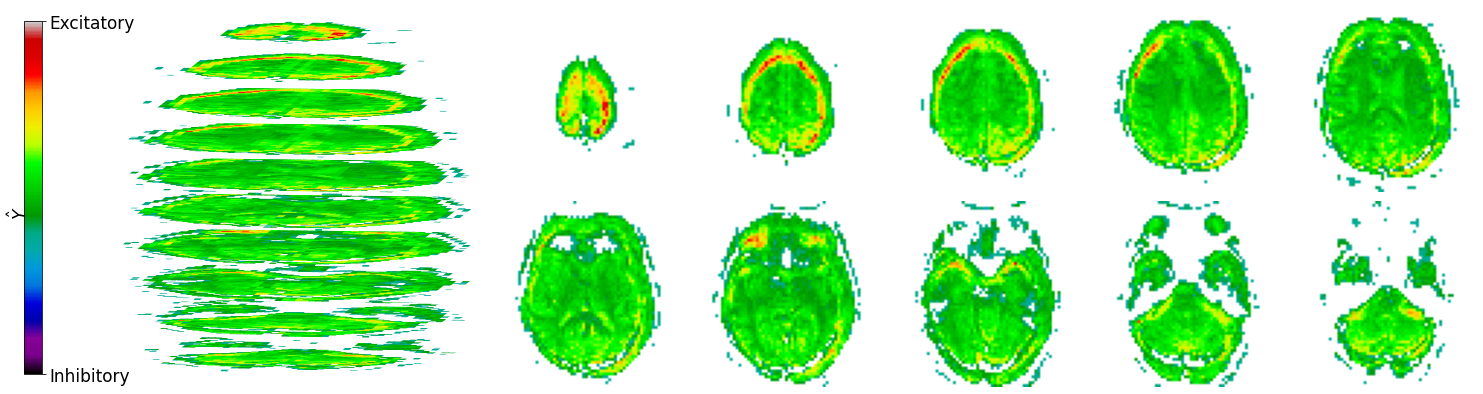

In [12]:
fig = viz_utils.plot_3D_representation_projected_slices(test_views[0], slice_label=False, threshold=getattr(data_utils, "threshold_plot_01"), legend_colorbar=r"$\hat{Y}$",max_min_legend=["Inhibitory","Excitatory"],)

## Explainability on the synthesized fMRI

Layer-wise Relevance Propagation (LRP) algorithm was proposed by Bach et al. 2015. This algorithm backpropagates the output back to the input in such a way that each feature is assigned the relevance it had for the output. 

The relevances are computed beginning at the output layer, $L_n$, for a network with $n$ layers. As such the relevances, $R_k$, of the last layer are propagated to the previous layer such that

$$R_j = \sum_k \frac{a_j w_{jk}}{\sum_j a_j w_{jk}} R_k,$$

where $R_j$ is one neuron activation of layer $L_{n-1}$, whose relevance is computed according to all neurons $k$ of layer $L_n$ that neuron $j$ is connected to. This process is done $\forall i \in \{1, \dots, n\}: L_i$.

Now we can use the fMRI synthesized view to check which regions of the synthesized brain had more relevance to the prediction. Let us first plot the explanations (absolute values of LRP) for schizophrenic individuals:

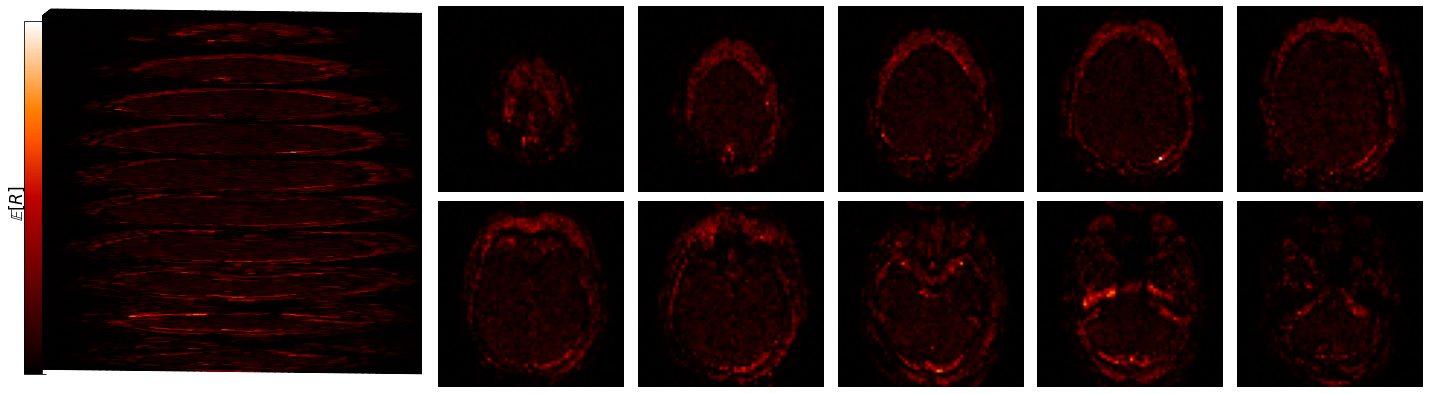

In [13]:
explainer = lrp.LRP(linearCLF.clf.model)
test_views_set = tf.data.Dataset.from_tensor_slices((test_views,y_test)).batch(1)
R=lrp.explain(explainer, test_views_set, verbose=True)
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(np.abs(R[np.where(y_test[:,1]==1.)]), axis=0),res_img=np.mean(test_views,axis=0),slice_label=False,cmap=plt.cm.gist_heat,threshold=0.0,legend_colorbar=r"$\mathbb{E}[R]$",max_min_legend=["",""])

Now we can compare the explanations of schizophrenic individuals with healthy control predictions:

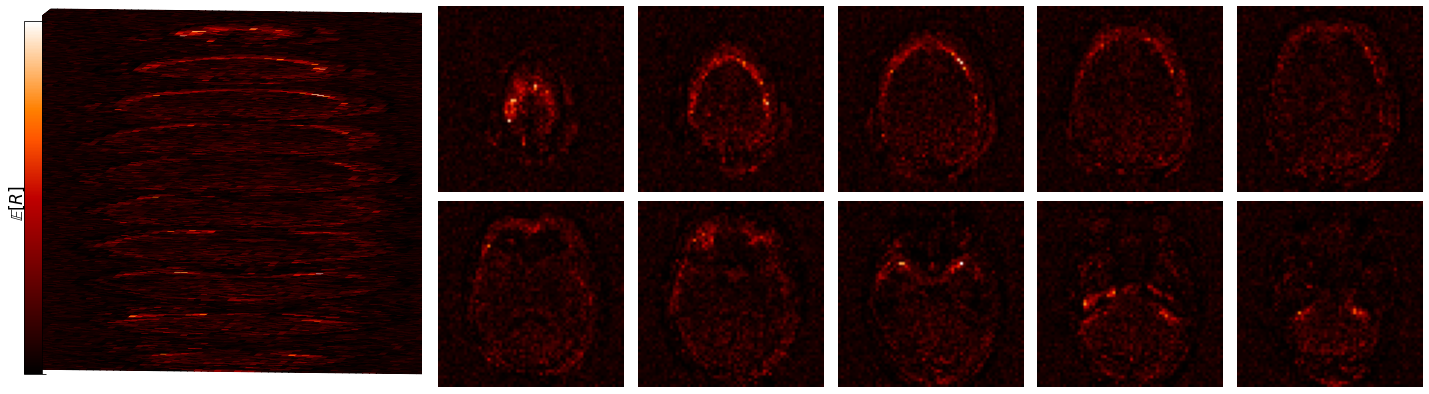

In [14]:
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(np.abs(R[np.where(y_test[:,1]==0.)]), axis=0),res_img=np.mean(test_views,axis=0),slice_label=False,cmap=plt.cm.gist_heat,threshold=0.0,legend_colorbar=r"$\mathbb{E}[R]$",max_min_legend=["",""])